In [206]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns

from utils import enrich

In [3]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()
2023-02-15 10:57:37.541745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 10:57:37.625511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 10:57:37.625530: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up 

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.0 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.3 pynndescent==0.5.7


In [4]:
adata = sc.read('2301_annot_patient_integrated_ambient_removed.h5ad')

In [24]:
adata.X = adata.layers['counts']
adata.obs['sample'] = adata.obs.patient.astype(str) + '_' + adata.obs.infected.astype(str) + '_' + adata.obs.treatment.astype(str) + '_' + adata.obs.cell_type.astype(str)

Get the pseudobulks.

In [50]:
%%time
adata_pb = dc.get_pseudobulk(adata, 'patient', 'sample', min_smpls=1)

In [51]:
adata_pb

View of AnnData object with n_obs × n_vars = 628 × 11568
    obs: 'patient', 'barcode_round', 'sample', 'treatment', 'treatment_virus', 'infected', 'batch', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', 'ambient'

Normalize.

In [53]:
adata_pb.layers['counts'] = adata_pb.X

In [54]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

Identify important PCA components.

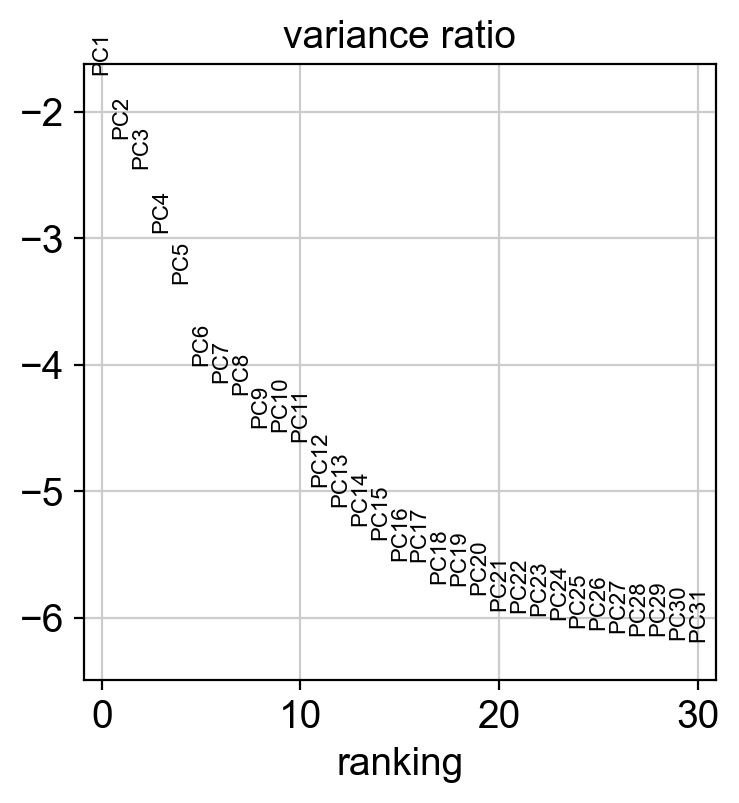

In [62]:
sc.pl.pca_variance_ratio(adata_pb, log=True)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping

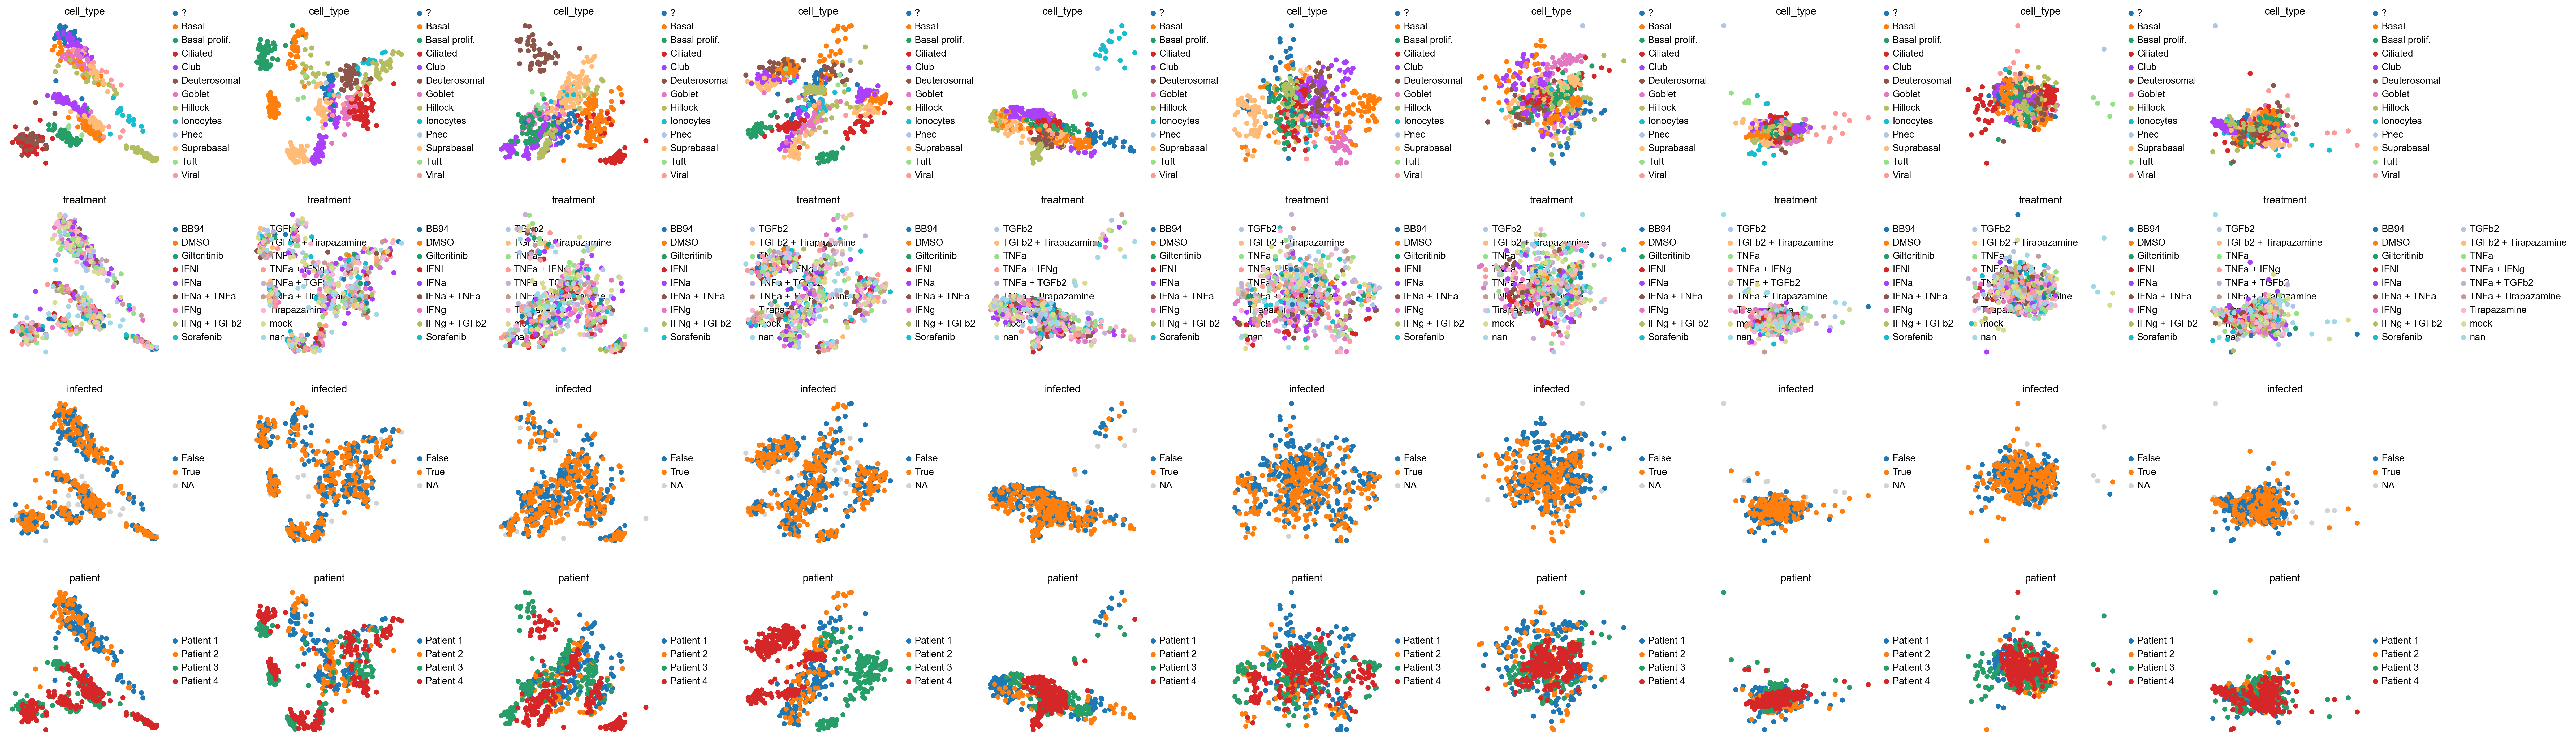

In [63]:
comps = ['1,2', '3,4', '5,6', '7,8', '9,10', '11,12', '13,14', '15,16', '17,18', '19,20']
sc.pl.pca(adata_pb, color=['cell_type', 'treatment', 'infected', 'patient'], components=comps, ncols=len(comps), wspace=.4)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping

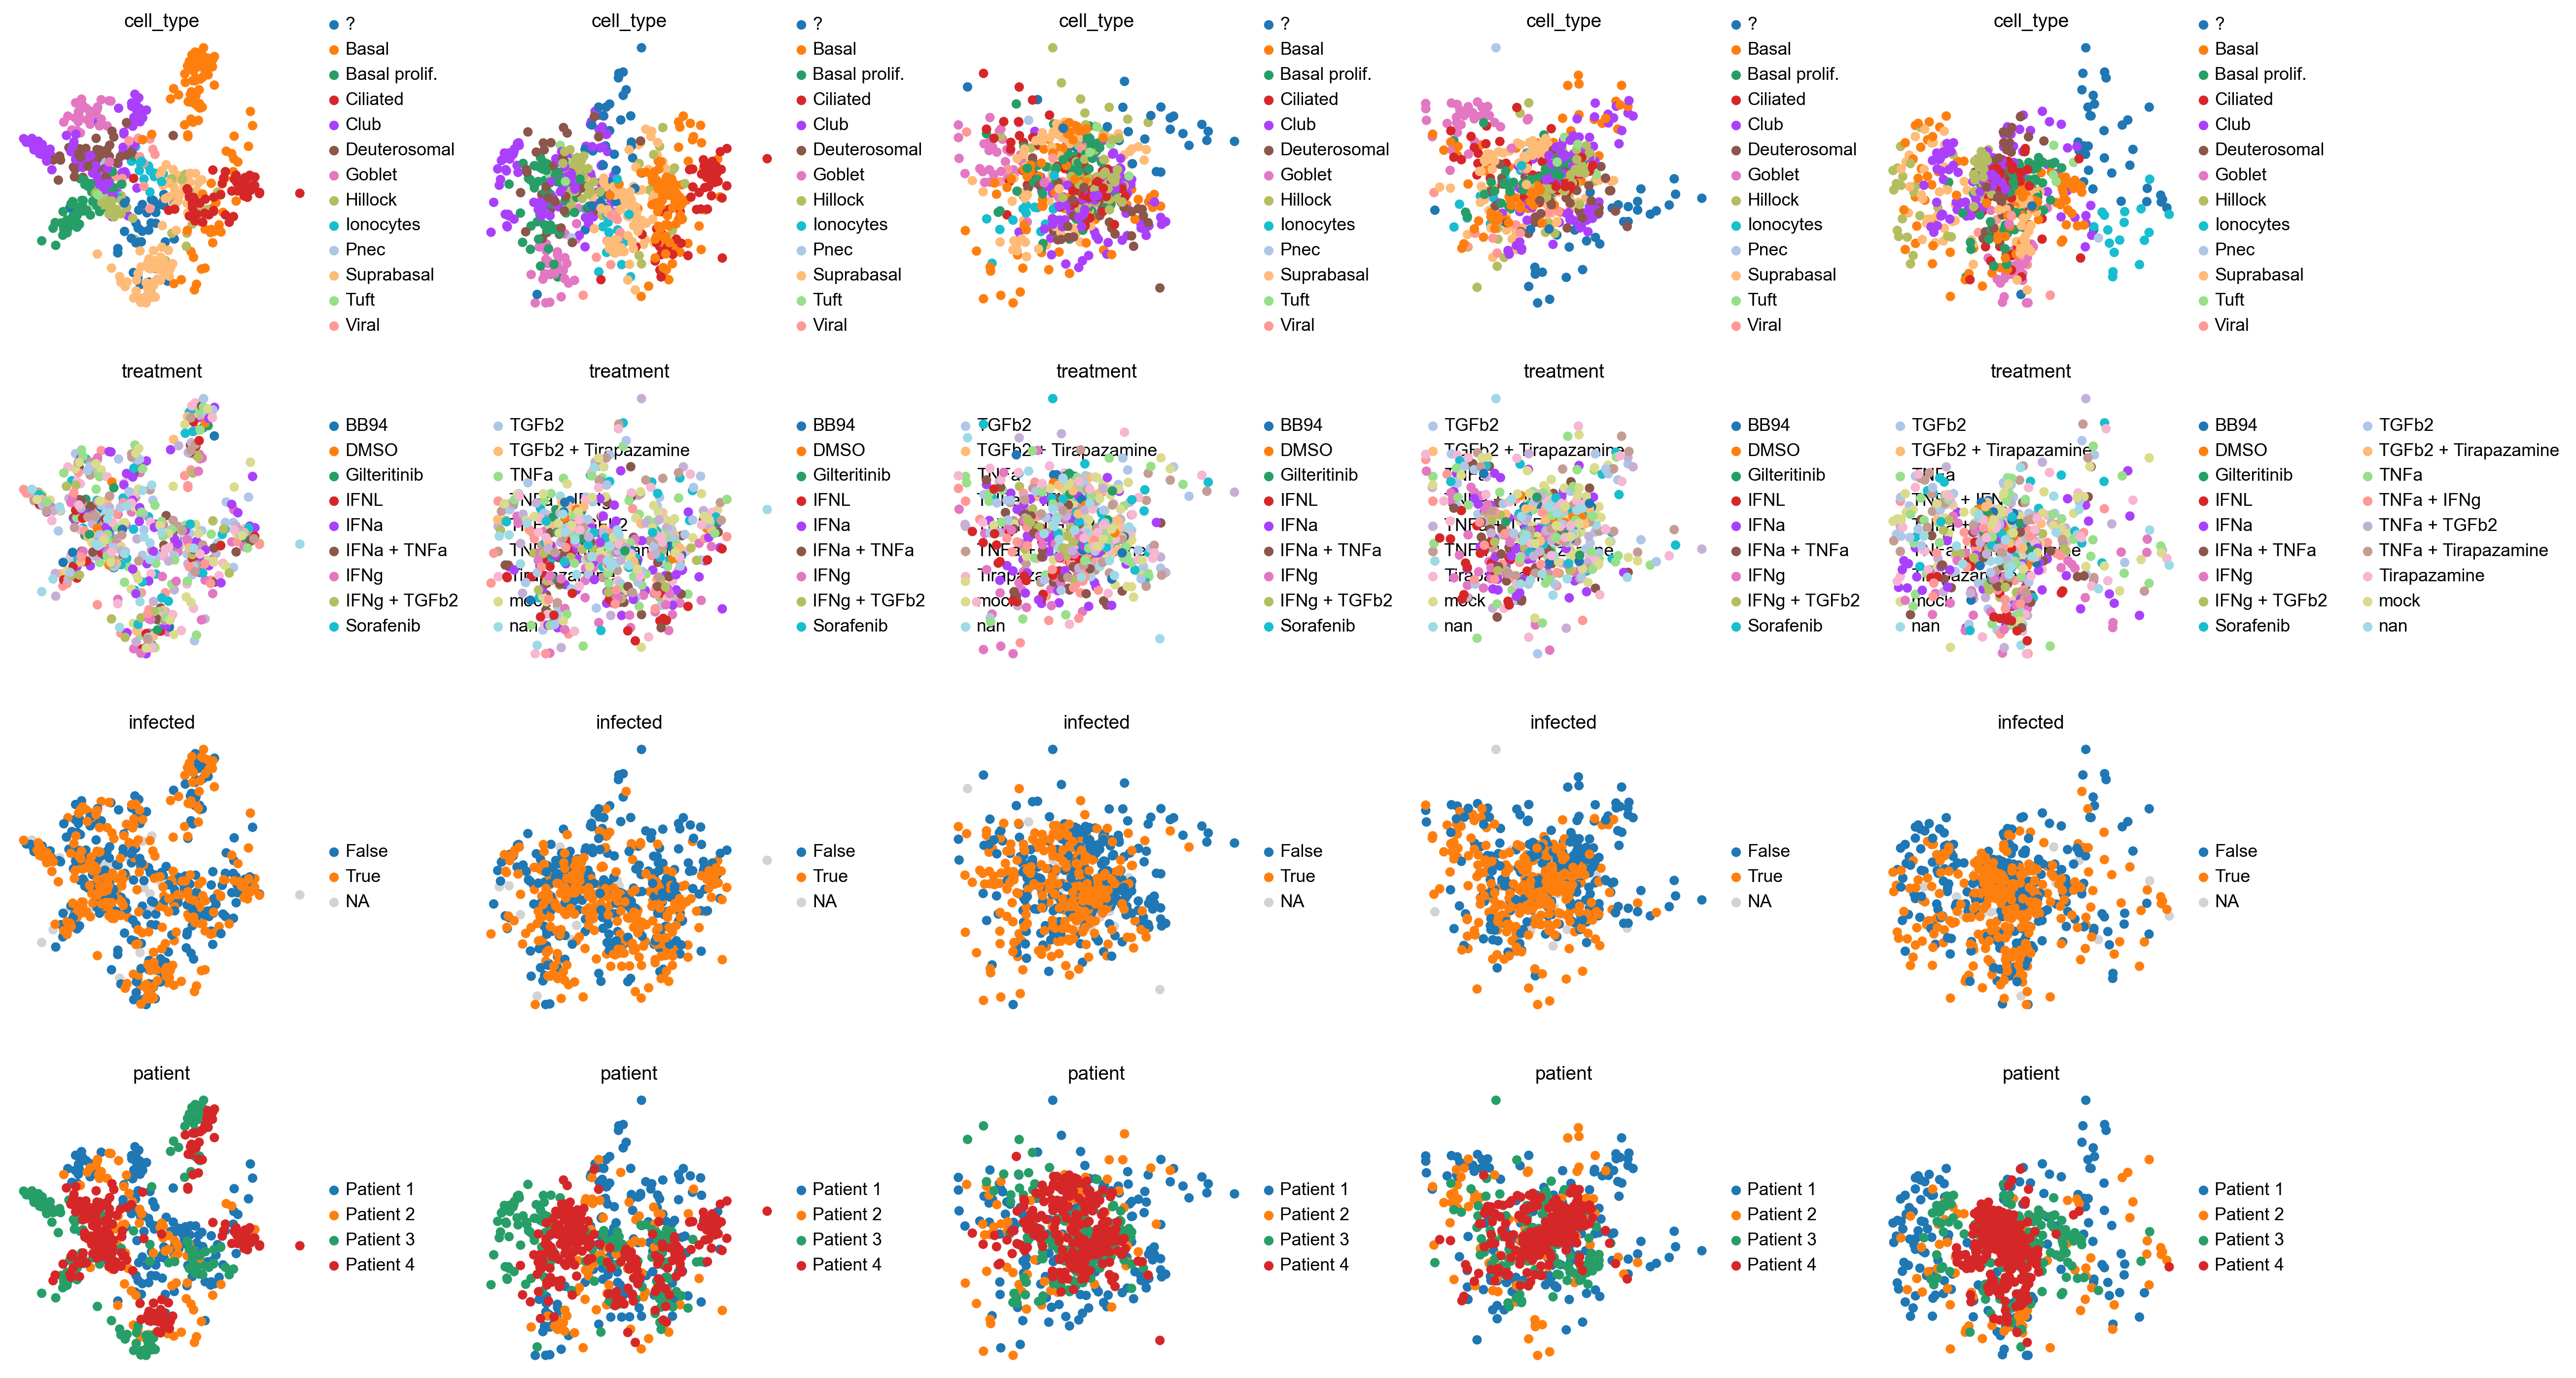

In [114]:
comps = ['5,11', '5,12', '12,13', '12,14', '9,12']
sc.pl.pca(adata_pb, color=['cell_type', 'treatment', 'infected', 'patient'], components=comps, ncols=len(comps), wspace=.4)

Look at the gene contributions of component 12, which captures the span of cytokine response the best. Which pathway does it span?

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


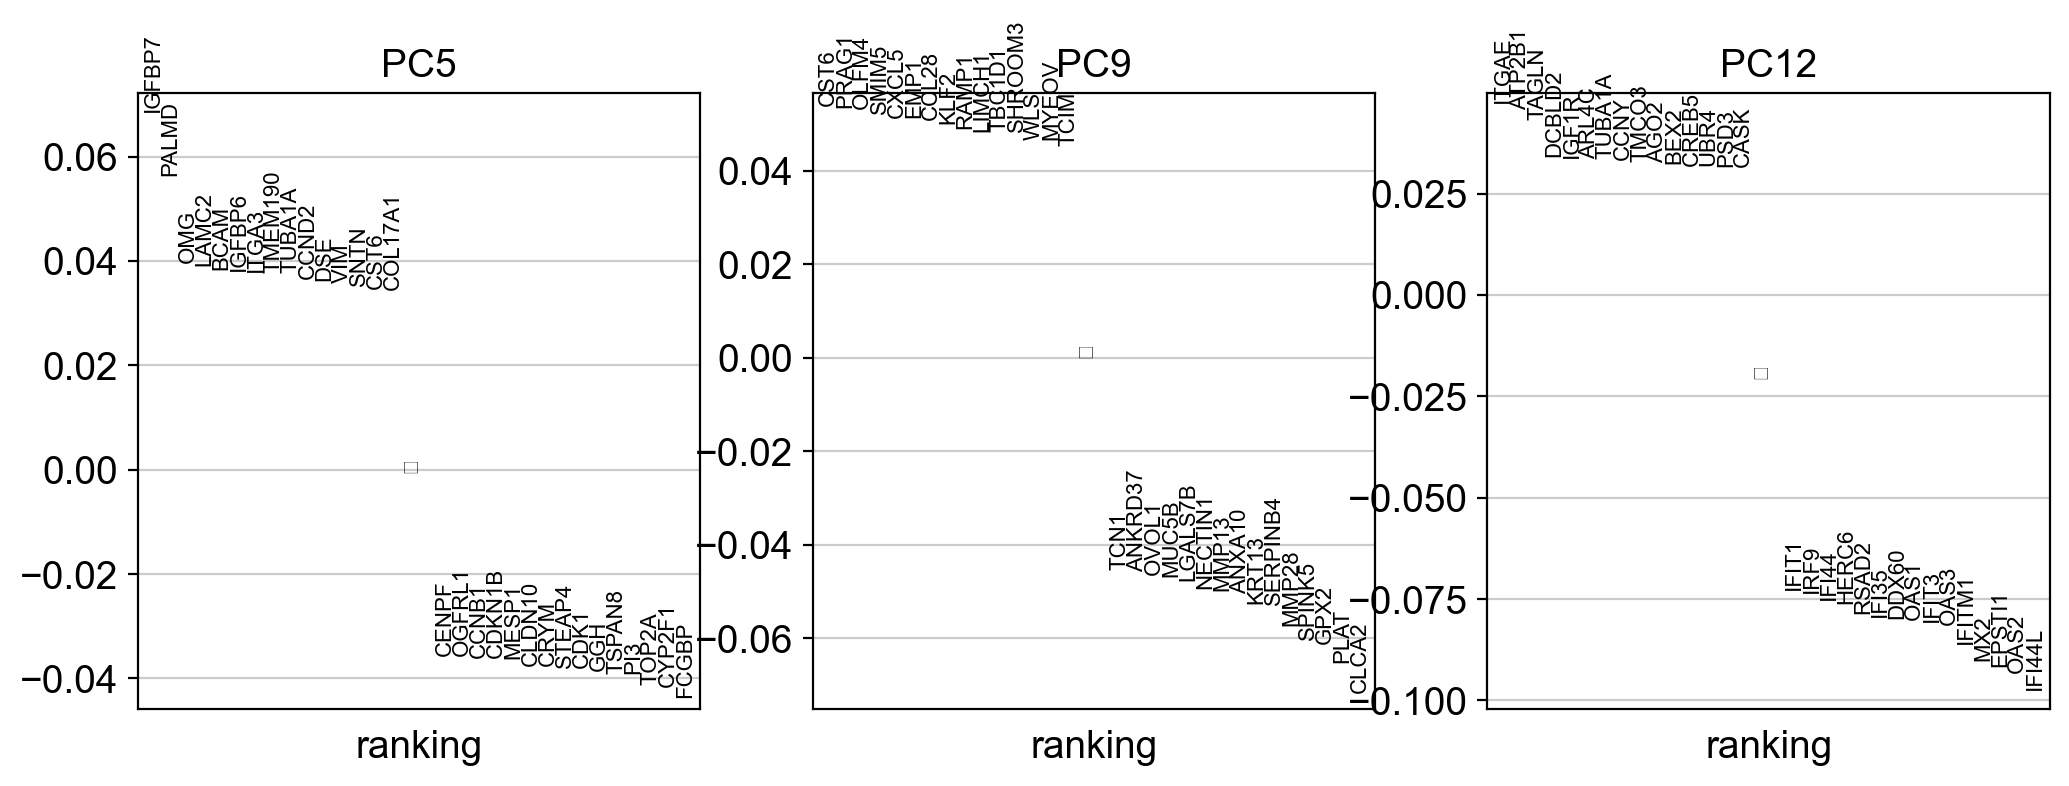

In [115]:
sc.pl.pca_loadings(adata_pb, components = '5,9,12')

In [72]:
df_loadings = pd.DataFrame(adata_pb.varm['PCs'], index=adata_pb.var_names)

In [163]:
for pc in [4, 8, 11]:
    print(pc)
    up_genes = list(df_loadings[pc].sort_values().index[-10:])
    up_genes.reverse()
    down_genes = list(df_loadings[pc].sort_values().index[:10])
    
    display(enrich(up_genes + down_genes, adata.var_names).head(10))

4


Empty DataFrame
Columns: [name, p_value, intersections]
Index: []

8


Empty DataFrame
Columns: [name, p_value, intersections]
Index: []

11


name       p_value  \
0                     defense response to symbiont  1.968093e-07   
1                        defense response to virus  1.968093e-07   
2                                response to virus  1.216357e-06   
3                     response to interferon-alpha  1.921107e-06   
4              regulation of ribonuclease activity  1.851184e-05   
5  negative regulation of viral genome replication  5.377809e-05   
6               defense response to other organism  5.377809e-05   
7                           innate immune response  8.076690e-05   
8              type I interferon signaling pathway  8.148344e-05   
9           cellular response to type I interferon  8.274565e-05   

                                       intersections  
0  [IFI44L, OAS2, MX2, IFITM1, OAS3, IFIT3, OAS1,...  
1  [IFI44L, OAS2, MX2, IFITM1, OAS3, IFIT3, OAS1,...  
2  [IFI44L, OAS2, MX2, IFITM1, OAS3, IFIT3, OAS1,...  
3                         [MX2, IFITM1, IFIT3, OAS1]  
4                                 [OAS2, OAS3, OAS1]  
5                         [OAS2, IFITM1, OAS3, OAS1]  
6  [IFI44L, OAS2, MX2, IFITM1, OAS3, IFIT3, OAS1,...  
7  [OAS2, MX2, IFITM1, OAS3, IFIT3, OAS1, DDX60, ...  
8                         [OAS2, IFITM1, OAS3, OAS1]  
9                         [OAS2, IFITM1, OAS3, OAS1]

### use loadings to plot differences in conditions

This is the set of genes that indicates viral infection and cytokine activation.

In [286]:
down_genes

['IFI44L',
 'OAS2',
 'EPSTI1',
 'MX2',
 'IFITM1',
 'OAS3',
 'IFIT3',
 'OAS1',
 'DDX60',
 'IFI35']

In [108]:
sc.tl.score_genes(adata, down_genes, score_name='PC12_score')

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


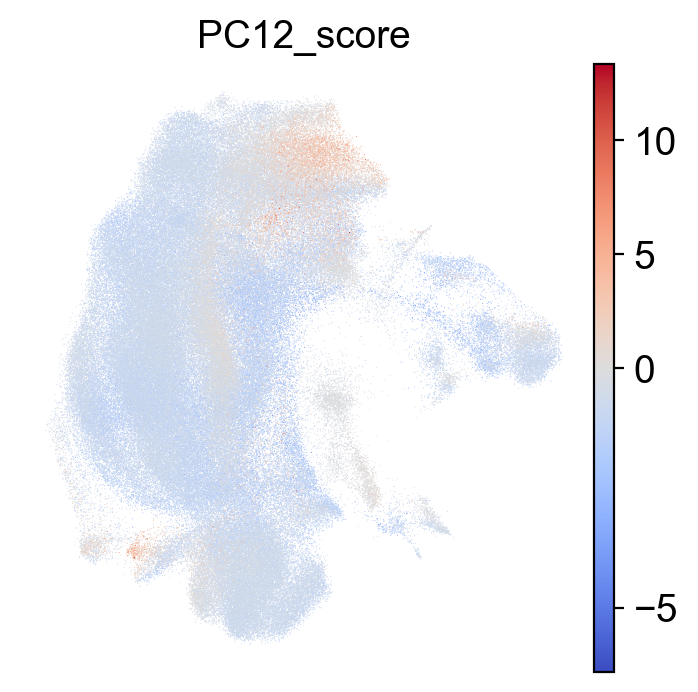

In [113]:
sc.pl.umap(adata, color='PC12_score', cmap='coolwarm', vcenter=0)

Get a score based on the responsive clusters.

In [284]:
adata = adata[adata.obs.treatment != 'nan']

In [287]:
%%time
# resp_clusters = ['11', '13', '19', '22']
# subset = adata[(adata.obs.patient.isin(['Patient 1', 'Patient 2'])) & (adata.obs.treatment == 'mock')]
subset = adata #[adata.obs.patient.isin(['Patient 1', 'Patient 2'])]

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(subset.X, subset.obs.treatment.isin(['mock']).values)

CPU times: user 4min 46s, sys: 14min 42s, total: 19min 28s
Wall time: 1min 27s


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [289]:
clf.score(subset.X, subset.obs.treatment.isin(['mock']).values)

0.8574810084773753

In [291]:
# subset.var.loc['VIM']

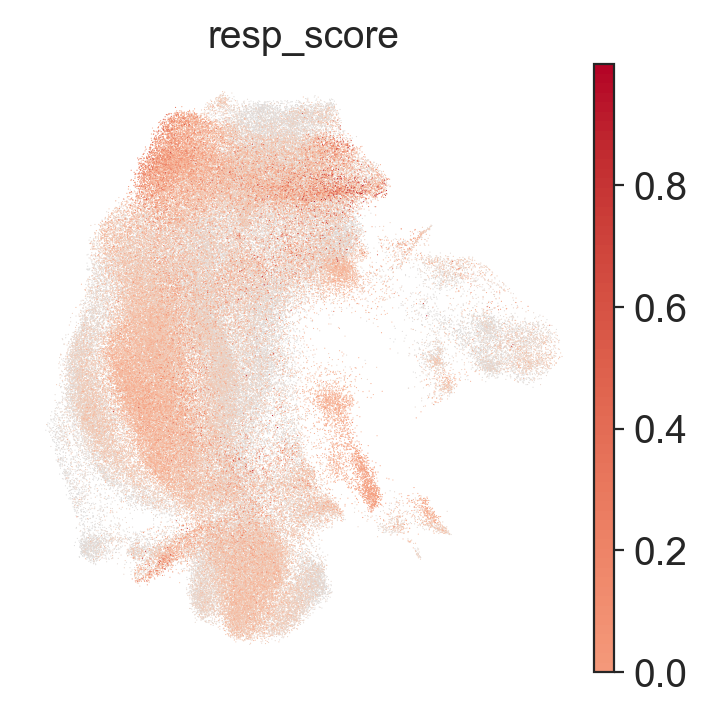

In [292]:
adata.obs['resp_score'] = clf.predict_proba(adata.X).T[1]
sc.pl.umap(adata, color='resp_score', cmap='coolwarm', vcenter=0)

Cool! Now we have a score captures the infection response, and a score that tells us if the cluster was primed to respond. Let's plot the treatments along this axis:

In [293]:
resp_df = -adata.obs.groupby(['treatment', 'infected']).mean()[['resp_score']]
# resp_df = adata[adata.obs.cell_type.isin(['?', 'Club'])].obs.groupby(['treatment', 'infected']).mean()[['resp_score']]
inf_df = adata.obs.groupby(['treatment', 'infected']).mean()[['PC12_score']]
df = pd.concat([resp_df, inf_df], axis=1).dropna()
df.head()

/tmp/ipykernel_126934/2712472789.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resp_df = -adata.obs.groupby(['treatment', 'infected']).mean()[['resp_score']]
/tmp/ipykernel_126934/2712472789.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  inf_df = adata.obs.groupby(['treatment', 'infected']).mean()[['PC12_score']]


resp_score  PC12_score
treatment    infected                        
BB94         False      -0.152898   -1.102997
             True       -0.153854   -0.958508
DMSO         True       -0.147906   -1.072717
Gilteritinib False      -0.142571   -1.156765
             True       -0.138836   -1.026253

Text(0, 0.5, 'immune response score')

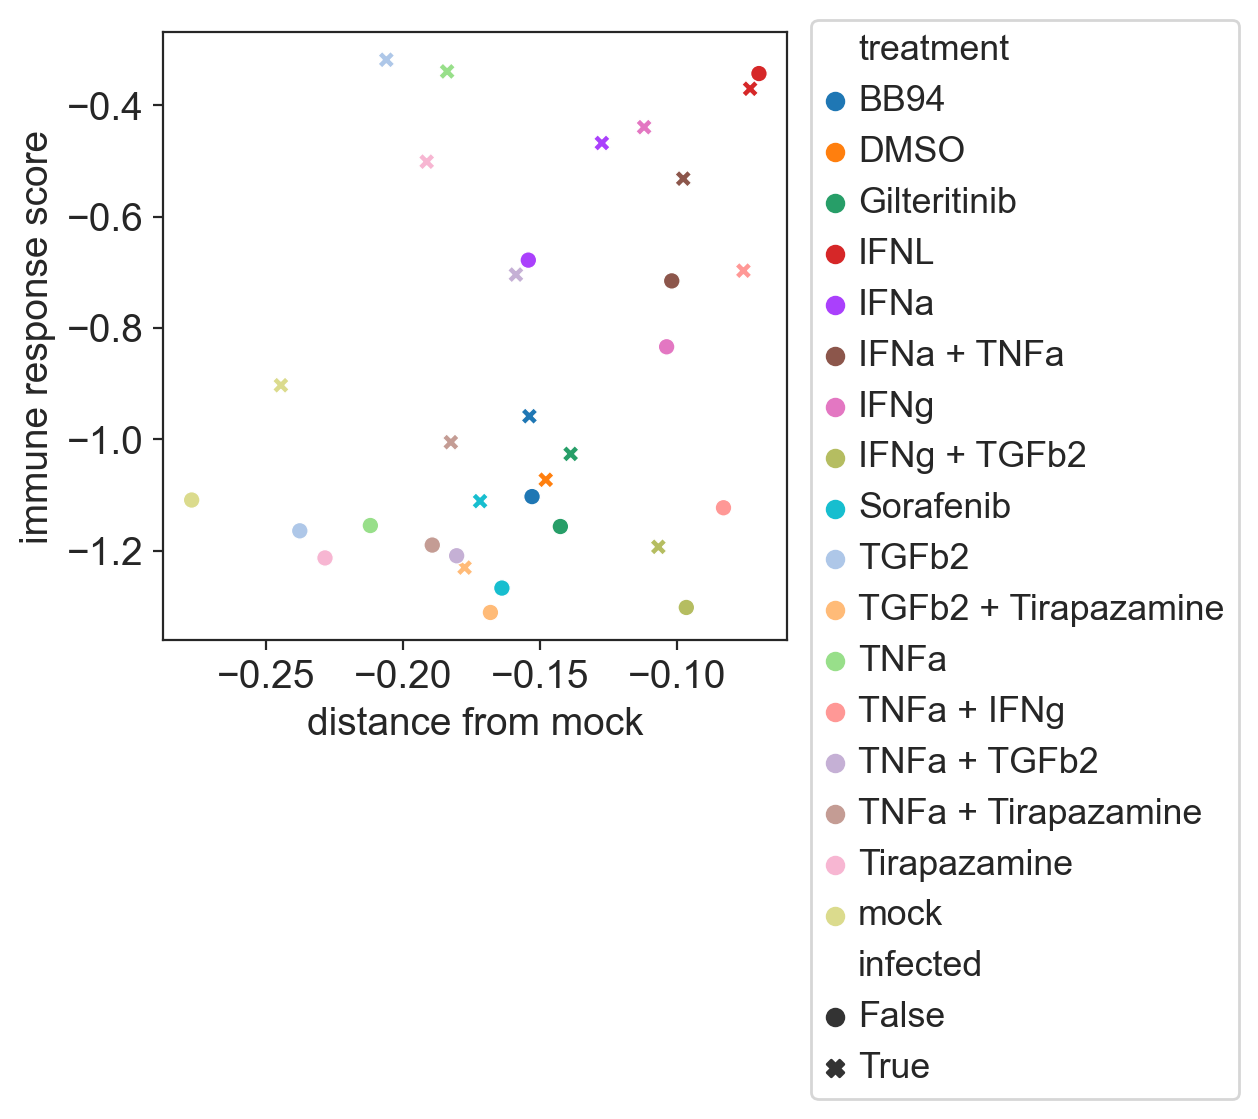

In [294]:
sns.scatterplot(data=df.reset_index(), x='resp_score', y='PC12_score', hue='treatment', style='infected')
plt.legend(bbox_to_anchor=(1.01, 1.05))
plt.xlabel('distance from mock')
plt.ylabel('immune response score')